# Week 10 - Information Theory

In [1]:
print("Hello, world!")

Hello, world!


In [2]:
import zlib # Also lzma

text = "Here is some text some text text text with repetition"
print(f"Original text {len(text)} bytes:", text)

text_bytes = text.encode('ascii')
comp = zlib.compress(text_bytes)
print(f"Compressed text {len(comp)} bytes:", comp)

decomp = zlib.decompress(comp)
print("Decompressed text: ", decomp.decode('ascii'))

ratio = len(comp) / len(text_bytes)
print(f"Compression ration: {ratio:.2f}")

Original text 53 bytes: Here is some text some text text text with repetition
Compressed text 43 bytes: b'x\x9c\xf3H-JU\xc8,V(\xce\xcfMU(I\xad(Ab!\x88\xf2\xcc\x92\x0c\x85\xa2\xd4\x82\xd4\x92\xcc\x92\xcc\xfc<\x00\x0c\x82\x13\xfc'
Decompressed text:  Here is some text some text text text with repetition
Compression ration: 0.81


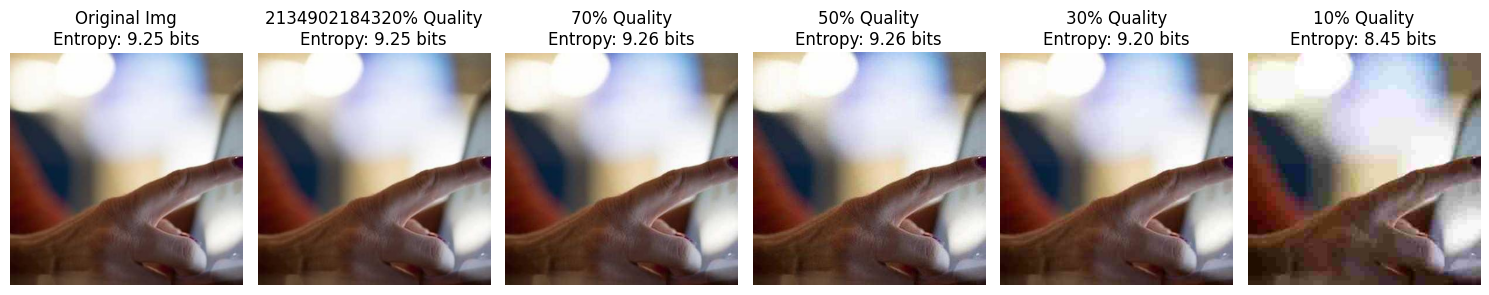

In [ ]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def entropy(img):
    hist = img.histogram()
    probs = [float(h) / sum(hist) for h in hist]
    return -sum(p * np.log2(p) for p in probs if p != 0)

def compress(img, quality=75):
    fname = f'../images/q_(quality).jpg'
    img.save(fname, 'JPEG', quality=quality)
    compressed = Image.open(fname)
    return compressed, entropy(compressed)

url = 'https://picsum.photos/400/400'
response = requests.get(url)
original = Image.open(BytesIO(response.content))

qualities = [90, 70, 50, 30, 10]
images    = [original]
entropies = [entropy(original)]
titles    = ['Original Img']
for q in qualities:
    img_c, img_h = compress(original, q)
    images.append(img_c)
    entropies.append(img_h)
    titles.append(f'{q}% Quality')

plt.figure(figsize = (15, 5))
for lcv, (img, ent, title) in enumerate(zip(images, entropies, titles), start=1):
    plt.subplot(1, len(images), lcv)
    plt.imshow(img)
    plt.title(f"{title}\nEntropy: {ent:.2f} bits")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Week 11 - Network Simulation

In [3]:
%pip install faker tqdm -q
from tqdm import tqdm
from queue import Queue
from faker import Faker
from time import time, sleep

Note: you may need to restart the kernel to use updated packages.


In [4]:
class Device:
    def __init__(self, name):
        self.ip = ""
        self.name = name
        self.inbox = Queue()

    def send(self, recip, msg):
        print(f'{self.name} is sending {len(msg)} bytes to {recip.ip}')
        for _ in tqdm(range(len(msg)), desc="Sending", ncols=100):
            sleep(0.25) # ~32 bits/s
        recip.inbox.put(msg.encode('ascii'))

    def receive(self):
        if not self.inbox.empty():
            msg = self.inbox.get().decode('ascii')
            print(f'{self.name} recieved a message: {msg}')
            return len(msg)
        return 0

In [8]:
class Network:
    def __init__(self):
        self.devices = []
        self.dhcp = Faker()
        self.start_time = time()
        self.usage = 0
    
    def add_device(self, device: Device):
        device.ip = self.dhcp.ipv4()
        self.devices.append(device)

    def sin_traffic(self):
        for device in self.devices:
            self.usage += device.receive()
    
    def display(self):
        print(f'Uptime: {time() - self.start_time:.4} seconds')
        print(f'Data usage: {self.usage} bytes')
        print("Connected devices:")
        for d in self.devices:
            print(f'{d.name}\t\t{d.ip}')

In [9]:
alice = Device("Alice")
bob = Device("Bob")

network = Network()
network.add_device(alice)
network.add_device(bob)
network.display()

while True:
    sender_name = input("Who are you (Alice/Bob)?")
    if sender_name == "Alice":
        sender, recip = alice, bob
    elif sender_name == "Bob":
        sender, recip = bob, alice
    else:
        print("Invalid name")
        continue

    msg = input("Enter your message: ")
    sender.send(recip, msg)
    network.sin_traffic()

    loop = input("Do you want to send another message (y/n): ")
    if loop not in "yes":
        break

network.display()

Uptime: 0.009393 seconds
Data usage: 0 bytes
Connected devices:
Alice		108.130.37.242
Bob		69.200.189.122


Alice is sending 28 bytes to 69.200.189.122


Sending: 100%|██████████████████████████████████████████████████████| 28/28 [00:07<00:00,  3.99it/s]


Bob recieved a message: 1 youre selfish 2 your jaded
Invalid name
Alice is sending 34 bytes to 69.200.189.122


Sending: 100%|██████████████████████████████████████████████████████| 34/34 [00:08<00:00,  3.99it/s]


Bob recieved a message: 4 talk a big game till youre naked
Uptime: 72.94 seconds
Data usage: 62 bytes
Connected devices:
Alice		108.130.37.242
Bob		69.200.189.122


# Week 12 - TCP-IP Model

In [9]:
%pip install faker tqdm termcolor -q
import random
from tqdm import tqdm
from time import sleep
from faker import Faker
from termcolor import colored

Note: you may need to restart the kernel to use updated packages.


In [23]:
def print_sleep(msg, seconds=1):
    print(msg)
    sleep(seconds)

def do_progress(length, desc, seconds=0.05):
    for _ in tqdm(range(length), desc=desc, ncols=100):
        sleep(seconds)

In [21]:
class ApplicationLayer:
    def __init__(self, data):
        self.data = data

    def prepare_data(self):
        print_sleep(colored("Application Layer: ", "cyan") + f"Preparing data '{self.data}'")
        return self.data.encode()
    
class TransportLayer:
    def __init__(self, protocol="TCP", port=80):
        self.protocol = protocol
        self.port = port
        self.sequence_num = random.randint(1, 1000)

        def prepare_segment(self, data):
            header = colored("Transport Layer: ", "magenta")
            if self.protocol == "TCP":
                print_sleep(header + f"Using TCP on Port {self.port} - Establish connection...")
                # TCP Handshake
                print_sleep(header + f"SYN packet (Seq={self.sequence_num})", 0.5)
                print_sleep(header + f"SYN-ACK packet (Seq={self.sequence_num+1})", 0.5)
                print_sleep(header + f"ACK packet - Connection established!", 0.5)
            else:
                print(header + f"Using UDP on Port {self.port} - No connection setup required")

            segment = f"{self.protocol}-Port-{self.port}-Segment-{self.sequence.num}|{data.decode()}"
            do_progress(len(segment), "Transport Layer Processing")
            return segment.encode()

class InternetLayer:
    def __init__(self, src_ip, dest_ip):
        self.src_ip = src_ip
        self.dest_ip = dest_ip

    def prepare_packet(self, segment):
        print_sleep(colored("Internet Layer: ", "yellow") +
                    f"Adding IP header (Source: {self.src_ip}, Destination: {self.dest_ip})")
        packet = f"IP:{self.src_ip}>{self.dest_ip}|{segment.decode()}"
        do_progress(len(packet), "Internet Layer Processing")
        return packet.encode()

class NetworkAccessLayer:
    def __init__(self, src_mac, dest_mac):
        self.src_mac = src_mac
        self.dest_mac = dest_mac
    
    def prepare_frame(self, packet):
        print_sleep(colored("Network Access Layer: ", "green") + 
                    f"Adding MAC header (Source: {self.src_mac}, Destination: {self.dest_mac})")
        frame = f"MAC:{self.src_mac}>{self.dest_mac}|{packet.decode()}"
        do_progress(len(frame), "Network Access Layer Processing")
        return frame.encode()

In [26]:
class InternetDevice:
    def __init__(self, name, ip, mac):
        self.name = name
        self.ip = ip
        self.mac = mac

    def send(self, dest_device, data, port=80):
        app_data = ApplicationLayer(data).prepare_data()
        segment = TransportLayer("TCP").prepare_segment(app_data)
        packet = InternetLayer(self.ip, dest_device.ip).prepare_packet(segment)
        frame = NetworkAccessLayer(self.mac, dest_device.mac).prepare_frame(packet)
        print_sleep(f"\n{self.name} is sending data to {dest_device.name} on port {port}")
        dest_device.receive(frame)

    def receive(self, frame):
        print(f"{self.name} received data:\n{frame.decode()}\n")
        print("Processing data through layers...") # In reverse order
        do_progress(5, "Network Access Layer Decapsulation", 0.1)
        split_frame = frame.decode().split("|")
        del split_frame[0] # Remove Mac header
        do_progress(5, "Internet Layer Decapsulation")
        split_frame = frame.decode().split("|")
        del split_frame[0] # Remove IP header
        do_progress(5, "Transport Layer Decapsulation")
        split_frame = frame.decode().split("|")
        del split_frame[0] # Remove TCP/UDP header
        do_progress(5, "Application Layer Decapsulation")
        print(f"\nData received:\n{split_frame[0]}")

In [27]:
router = Faker()
device1 = InternetDevice("ComputerA", router.ipv4(), router.mac_address())
device2 = InternetDevice("ComputerB", router.ipv4(), router.mac_address())
device1.send(device2, "Hello from ComputerA!", port=80)

Application Layer: Preparing data 'Hello from ComputerA!'


AttributeError: 'TransportLayer' object has no attribute 'prepare_segment'

# Week 13 - Encryption

In [11]:
%pip install sympy -q
import sympy

class RSA:
    def __init__(self, p=1, q=-1):
        p = sympy.randprime(500, 1_000_000) if p == -1 else p
        q = sympy.randprime(500, 1_000_000) if q == -1 else q
        self.n = p * q
        self.phi = (p-1) * (q-1)
        self.e = 2
        while sympy.gcd(self.e, self.phi) != 1:
            self.e += 1
        self.d = pow(self.e, -1, self.phi) # e**-1 % phi

    def encrypt(self, msg):
        cipher = [pow(ord(m), self.e, self.n) for m in msg]
        return cipher
    
    def decrypt(self, cipher):
        msg = ''.join([chr(pow(c, self.d, self.n)) for c in cipher])
        return msg


Note: you may need to restart the kernel to use updated packages.


In [12]:
import base64
import numpy as np

rsa = RSA(p=61, q=53)

message = input("Enter a message: ")
print("Entered:", message)
e_msg = rsa.encrypt(message)
print("Encrypted message:", e_msg)
print("Encrypted (base64):", base64.b64encode(np.array(e_msg)))

d_msg = rsa.decrypt(e_msg)
print("Decrypted message:", d_msg)


Entered: hello
Encrypted message: [3052, 3071, 1877, 1877, 3183]
Encrypted (base64): b'7AsAAAAAAAD/CwAAAAAAAFUHAAAAAAAAVQcAAAAAAABvDAAAAAAAAA=='
Decrypted message: hello


# Week 14 - Quantum Computing


In [1]:
%pip install qiskit qiskit-aer -q
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# Textbook: qiskit.org/learn
# IBM QCs: quantum.ibm.com

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


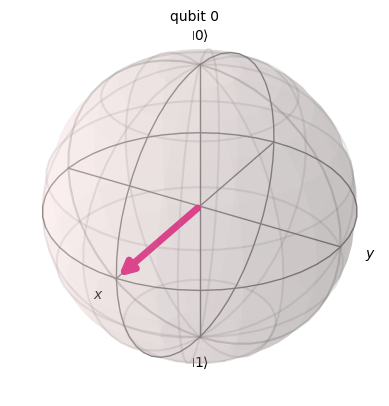

In [2]:
qc = QuantumCircuit(1, 1)  # 1 qubit, 1 classical bit
# The classical bit stores the classical output

# Apply Hadamard gate (enter superposition)
qc.h(0)

# Visualize on a Block sphere
qc.save_statevector()
sim = AerSimulator()
qobj = transpile(qc, sim)
result = sim.run(qobj).result()
statevector = result.get_statevector()
print(statevector)
plot_bloch_multivector(statevector)

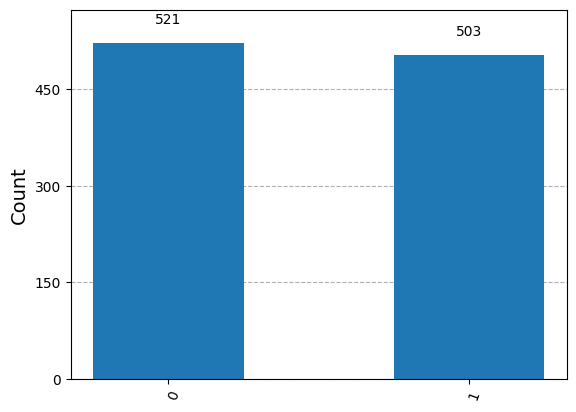

In [3]:
# Measure the qubit
qc.measure([0], [0])

# Execute 1024 times and get probability distribution
counts = sim.run(qc).result().get_counts()
plot_histogram(counts)

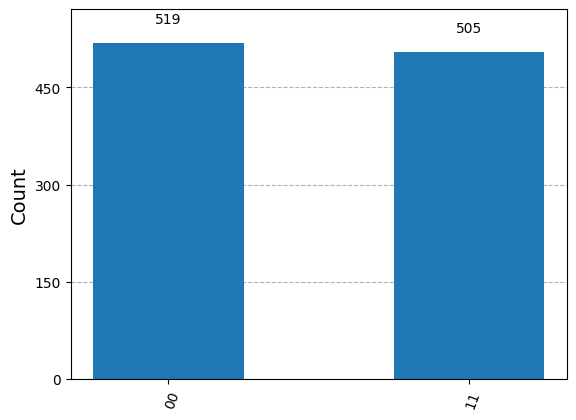

In [4]:
qc_entangle = QuantumCircuit(2, 2)  # 2 qubits, 2 bits

# Create a Bell State (entanglement)
qc_entangle.h(0)  # Superposition
qc_entangle.cx(0, 1)  # Controlled-NOT [CNOT] gate (entangle)
qc_entangle.measure([0,1], [0,1])

qc_entangle.save_statevector()
sim_result = sim.run(qc_entangle).result()
counts = sim_result.get_counts()
plot_histogram(counts)

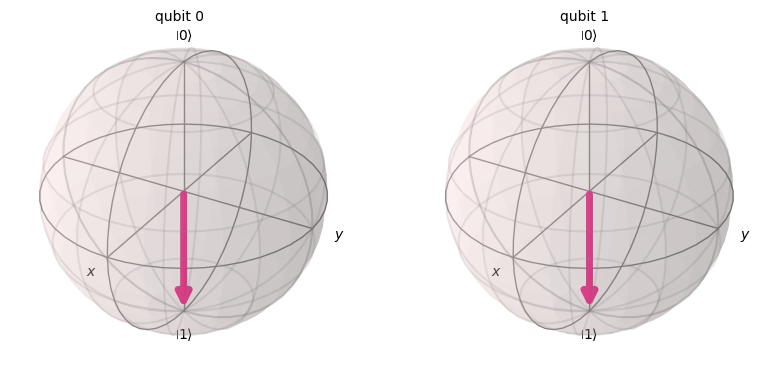

In [5]:
statevectors = sim_result.get_statevector()
plot_bloch_multivector(statevectors)